## Imports

In [ ]:
!pip install torcheval
from torcheval.metrics.functional import binary_auroc, binary_auprc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.3 MB/s eta 0:00:00


In [ ]:
!pip install tsai
from tsai.all import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.3/324.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x8

In [ ]:
from pydrive2.auth import GoogleAuth
from google.colab import drive
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1HDneuK6vRgzF1HrJWyDXqXp2ApNBZoKI' # USDT con 3 ATR
download = drive.CreateFile({'id': file_id})
download.GetContentFile('Crypto.csv')

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Modelos: Inception, TST, TransformerModel
df = pd.read_csv('Crypto.csv', parse_dates=['startDate', 'endDate'])
df.sort_values(by='startDate', inplace=True)
df.dropna(inplace=True)
df.head()

,open_1,high_1,low_1,close_1,volume_1,open_2,high_2,low_2,close_2,volume_2,...,open_14,high_14,low_14,close_14,volume_14,startDate,endDate,coin,profits,Partitor
1,-0.0345,0.0944,0.0007,0.0970,0.6370,0.0993,0.0083,0.1277,0.0146,0.0015,...,-0.0420,-0.0046,0.0282,0.0035,0.1504,2018-01-17,2018-02-01,BTC,-0.1672,TRAIN
4210,-0.0116,0.1141,0.0305,0.1164,0.9552,0.1166,-0.0109,0.0618,-0.0403,1.5973,...,-0.0894,-0.0954,-0.0064,-0.0247,-0.3211,2018-01-17,2018-02-01,LTC,-0.1363,TRAIN
9874,0.0220,0.1691,0.0409,0.1447,1.2280,0.1472,0.0652,0.1244,0.0885,-0.1193,...,-0.0231,-0.0071,0.0034,-0.0548,-0.0125,2018-01-17,2018-02-01,ETH,-0.0006,TRAIN
2097,-0.0199,0.0485,0.0324,0.0503,0.5776,0.0369,0.0502,0.0380,0.0790,0.0388,...,-0.0653,0.0607,0.0101,-0.0584,0.8892,2018-01-17,2018-02-01,BNB,-0.2339,TRAIN
2098,0.0369,0.0502,0.0380,0.0790,0.0388,0.0770,-0.0044,0.0381,-0.0338,0.4590,...,-0.0561,-0.1682,-0.4602,-0.2900,0.6381,2018-01-18,2018-02-01,BNB,-0.2932,TRAIN


Particiono dataset en train, validacion y test y creo datasets.

In [ ]:
exclude_cols = ['startDate', 'endDate', 'Partitor', 'profits', 'coin']

df_train = df[df.Partitor=='TRAIN'].filter(regex='^(?!volume)')
df_val = df[df.Partitor=='VALIDATE'].filter(regex='^(?!volume)')
df_test = df[df.Partitor=='TEST'].filter(regex='^(?!volume)')

X_train, y_train = df_train.drop(exclude_cols,axis=1), df_train['profits']
X_val, y_val = df_val.drop(exclude_cols,axis=1), df_val['profits']
X_test, y_test = df_test.drop(exclude_cols,axis=1), df_test['profits']

y_train_binary, y_val_binary, y_test_binary = y_train > 0, y_val > 0, y_test > 0

print("Shape train:", X_train.shape, y_train.shape)
print("Shape eval:", X_val.shape, y_val.shape)
print("Shape test:", X_test.shape, y_test.shape)

Shape train: (10231, 56) (10231,)
Shape eval: (2430, 56) (2430,)
Shape test: (6062, 56) (6062,)


In [ ]:
import torch.utils.data as data_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_dataset(X, y, n_days = 14):

    # Convert to tensors
    X_tensor = torch.tensor(X.values.astype(np.float32)).to(device)
    X_tensor = X_tensor.reshape(len(X),n_days,-1).permute(0,2,1)
    y_tensor = torch.tensor(y.values.astype(np.float32)).to(device)

    # Create dataset
    dataset = data_utils.TensorDataset(X_tensor, y_tensor)

    return dataset

train_data = create_dataset(X_train, y_train_binary)
val_data = create_dataset(X_val, y_val_binary)
test_data = create_dataset(X_test, y_test_binary)

## Trainer

In [ ]:
def trainer(train_dataset, val_dataset, model, args, score_fn=binary_auroc, early_stopping_rounds=10):
  torch.manual_seed(42)
  model = model.to(device)

  bs = args['batch_size']
  n_epochs = args['n_epochs']
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=bs, shuffle=False)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
  loss_fn = nn.BCEWithLogitsLoss()

  train_loss_avg = []
  val_loss_avg = []
  train_score = []
  val_score = []
  best = 0
  early_stopping_count = 0

  for epoch in range(n_epochs):

    print(f"Epoch {epoch+1}/{n_epochs}")
    # Training
    model.train()
    train_loss_avg.append(0)
    train_targets = []
    train_probas = []
    num_batches = 0

    for inputs, targets in tqdm(train_loader, unit=" batch"):
      y_logits = model(inputs).squeeze() # Forward pass
      optimizer.zero_grad() # Backpropagation
      loss = loss_fn(y_logits, targets) # Calculate loss
      loss.backward() # Backward pass
      optimizer.step() # Update weights

      train_probas.append(torch.sigmoid(y_logits))
      train_targets.append(targets)
      train_loss_avg[-1] += loss.item()
      num_batches += 1

    train_probas = torch.cat(train_probas)
    train_targets = torch.cat(train_targets)
    train_score.append(score_fn(train_probas, train_targets).item())
    train_loss_avg[-1] /= num_batches

    # Validation
    num_batches = 0
    model.eval()
    val_probas = []
    val_targets = []
    val_loss_avg.append(0)

    with torch.no_grad():
      for inputs, targets in val_loader:
        y_logits = model(inputs).squeeze()
        loss = loss_fn(y_logits, targets)

        val_loss_avg[-1] += loss.item()
        val_probas.append(torch.sigmoid(y_logits))
        val_targets.append(targets)
        num_batches += 1

    val_probas = torch.cat(val_probas)
    val_targets = torch.cat(val_targets)
    val_score.append(score_fn(val_probas, val_targets).item())
    val_loss_avg[-1] /= num_batches

    # Print current epoch results
    print(f"Train Loss: {train_loss_avg[-1]:.4f} | Val Loss: {val_loss_avg[-1]:.4f} | Train Score: {train_score[-1]:.4f} | Val Score: {val_score[-1]:.4f}")

    # Save best current model parameters
    if val_score[-1] > best:
      early_stopping_count = 0 # Reset early stopping
      best = val_score[-1]
      torch.save(model.state_dict(), "best.pt")
    else:
      early_stopping_count += 1 # Increment count for early stopping

    # Check if we have to stop training
    if early_stopping_count == early_stopping_rounds:
      print(f"Early stopping at epoch {epoch+1}")
      break

  history = {
    'Train_Loss' : train_loss_avg,
    'Val_Loss' : val_loss_avg,
    'Train Score' : train_score,
    'Val_Score': val_score
  }

  df_history = pd.DataFrame(history)
  df_history.index = df_history.index + 1
  df_history.index.name = 'Epoch'

  return pd.DataFrame(df_history)

### Plotting

In [ ]:
import seaborn as sns

def plot_curves(results):
    sns.set(style="darkgrid")
    epochs = results.index

    # Create a figure with two subplots, one on top of the other
    fig, axes = plt.subplots(1, 2, figsize=(11, 5), sharex=True)

    # Plot training and validation loss
    axes[0].plot(epochs, results['Train_Loss'], label='Train Loss', color='blue')
    axes[0].plot(epochs, results['Val_Loss'], label='Val Loss', color='orange')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()

    # Plot training and validation scores
    axes[1].plot(epochs, results['Train Score'], label='Train Score', color='blue')
    axes[1].plot(epochs, results['Val_Score'], label='Val Score', color='orange')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Score')
    axes[1].set_title('Training and Validation Scores')
    axes[1].legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

## TST (Time Series Transformer)

### TST args and *kwargs

Usual values are the ones that appear in the "Attention is all you need" and "A Transformer-based Framework for Multivariate Time Series Representation Learning" papers.

The default values are the ones selected as a default configuration in the latter.

* c_in: the number of features (aka variables, dimensions, channels) in the time series dataset. dls.var
* c_out: the number of target classes. dls.c
* seq_len: number of time steps in the time series. dls.len
* max_seq_len: useful to control the temporal resolution in long time series to avoid memory issues. Default. None.
* d_model: total dimension of the model (number of features created by the model). Usual values: 128-1024. Default: 128.
* n_heads:  parallel attention heads. Usual values: 8-16. Default: 16.
* d_k: size of the learned linear projection of queries and keys in the MHA. Usual values: 16-512. Default: None -> (d_model/n_heads) = 32.
* d_v: size of the learned linear projection of values in the MHA. Usual values: 16-512. Default: None -> (d_model/n_heads) = 32.
* d_ff: the dimension of the feedforward network model. Usual values: 256-4096. Default: 256.
* dropout: amount of residual dropout applied in the encoder. Usual values: 0.-0.3. Default: 0.1.
* activation: the activation function of intermediate layer, relu or gelu. Default: 'gelu'.
* num_layers: the number of sub-encoder-layers in the encoder. Usual values: 2-8. Default: 3.
* fc_dropout: dropout applied to the final fully connected layer. Usual values: 0-0.8. Default: 0.
* pe: type of positional encoder. Available types: None, 'gauss' (default), 'lin1d', 'exp1d', '2d', 'sincos', 'zeros'. Default: 'gauss'.
* learn_pe: learned positional encoder (True, default) or fixed positional encoder. Default: True.
* flatten: this will flattent the encoder output to be able to apply an mlp type of head. Default=True.
* custom_head: custom head that will be applied to the network. It must contain all kwargs (pass a partial function). Default: None.
* y_range: range of possible y values (used in regression tasks). Default: None
* kwargs: nn.Conv1d kwargs. If not {}, a nn.Conv1d with those kwargs will be applied to original time series.

### Tips on how to use transformers:

* In general, transformers require a lower lr compared to other time series models when used with the same datasets. It's important to use `learn.lr_find()` to learn what a good lr may be.

* The paper authors recommend to standardize data by feature. This can be done by adding `TSStandardize(by_var=True` as a batch_tfm when creating the `TSDataLoaders`.

* When using TST with a long time series, you may use `max_w_len` to reduce the memory size and thus avoid gpu issues.`

* I've tried different types of positional encoders. In my experience, the default one works just fine.

* In some of the cases I've used it, you may need to increase the dropout > .1 and/ or fc_dropout > 0 in order to achieve a good performance.

* You may also experiment with other key hyperparameters like d_model, n_layers, n_heads, etc, but I have not seen major difference in my experience.

In [ ]:
c_in = 4
c_out = 1
seq_len = 14
model = TST(c_in, c_out, seq_len, n_heads=4, dropout=0.3, fc_dropout=0.5)
model

TST(
  (W_P): Linear(in_features=4, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (encoder): _TSTEncoder(
    (layers): ModuleList(
      (0-2): 3 x _TSTEncoderLayer(
        (self_attn): _MultiHeadAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=False)
          (W_K): Linear(in_features=128, out_features=128, bias=False)
          (W_V): Linear(in_features=128, out_features=128, bias=False)
          (W_O): Linear(in_features=128, out_features=128, bias=False)
        )
        (dropout_attn): Dropout(p=0.3, inplace=False)
        (batchnorm_attn): Sequential(
          (0): Transpose(1, 2)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Transpose(1, 2)
        )
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.3, inplace=False)
          (3): Linear(in_featu

SuggestedLRs(valley=0.0006918309954926372)

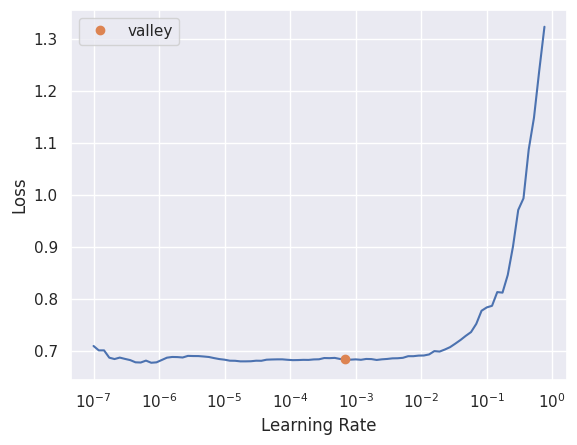

In [ ]:
bs = 24

dls = TSDataLoaders.from_dsets(train_data, val_data, bs=bs, device=device) #batch_tfms=TSStandardize(by_var=True)
learn = Learner(dls, model, loss_func=BCEWithLogitsLossFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learn.lr_find()

### Train

In [ ]:
args = {
    'n_epochs': 100,
    'batch_size': 24,
    'lr': 5e-4,
    'weight_decay': 1e-5
}

res = trainer(train_data, val_data, model, args, early_stopping_rounds=25)

Epoch 1/100


100%|██████████| 427/427 [00:04<00:00, 96.19 batch/s]


Train Loss: 0.7216 | Val Loss: 0.6923 | Train Score: 0.4992 | Val Score: 0.5246
Epoch 2/100


100%|██████████| 427/427 [00:05<00:00, 79.28 batch/s]


Train Loss: 0.7157 | Val Loss: 0.6940 | Train Score: 0.5034 | Val Score: 0.5257
Epoch 3/100


100%|██████████| 427/427 [00:04<00:00, 95.29 batch/s]


Train Loss: 0.7121 | Val Loss: 0.7087 | Train Score: 0.5029 | Val Score: 0.5282
Epoch 4/100


100%|██████████| 427/427 [00:05<00:00, 80.83 batch/s]


Train Loss: 0.7115 | Val Loss: 0.6906 | Train Score: 0.5039 | Val Score: 0.5135
Epoch 5/100


100%|██████████| 427/427 [00:04<00:00, 95.94 batch/s]


Train Loss: 0.7098 | Val Loss: 0.6905 | Train Score: 0.5093 | Val Score: 0.5149
Epoch 6/100


100%|██████████| 427/427 [00:04<00:00, 94.76 batch/s]


Train Loss: 0.7109 | Val Loss: 0.6903 | Train Score: 0.4989 | Val Score: 0.5098
Epoch 7/100


100%|██████████| 427/427 [00:05<00:00, 71.62 batch/s]


Train Loss: 0.7076 | Val Loss: 0.6988 | Train Score: 0.5016 | Val Score: 0.4951
Epoch 8/100


100%|██████████| 427/427 [00:04<00:00, 95.38 batch/s]


Train Loss: 0.7099 | Val Loss: 0.7037 | Train Score: 0.4914 | Val Score: 0.5150
Epoch 9/100


100%|██████████| 427/427 [00:05<00:00, 77.04 batch/s]


Train Loss: 0.7034 | Val Loss: 0.6911 | Train Score: 0.4958 | Val Score: 0.5072
Epoch 10/100


100%|██████████| 427/427 [00:04<00:00, 94.33 batch/s]


Train Loss: 0.6988 | Val Loss: 0.6908 | Train Score: 0.5088 | Val Score: 0.5048
Epoch 11/100


100%|██████████| 427/427 [00:04<00:00, 89.95 batch/s]


Train Loss: 0.6981 | Val Loss: 0.6906 | Train Score: 0.5152 | Val Score: 0.5120
Epoch 12/100


100%|██████████| 427/427 [00:05<00:00, 80.85 batch/s]


Train Loss: 0.6969 | Val Loss: 0.6920 | Train Score: 0.5212 | Val Score: 0.5110
Epoch 13/100


100%|██████████| 427/427 [00:04<00:00, 94.91 batch/s]


Train Loss: 0.6976 | Val Loss: 0.6935 | Train Score: 0.5169 | Val Score: 0.5098
Epoch 14/100


100%|██████████| 427/427 [00:05<00:00, 78.02 batch/s]


Train Loss: 0.6948 | Val Loss: 0.6942 | Train Score: 0.5244 | Val Score: 0.5098
Epoch 15/100


100%|██████████| 427/427 [00:05<00:00, 75.97 batch/s]


Train Loss: 0.6952 | Val Loss: 0.6999 | Train Score: 0.5262 | Val Score: 0.4974
Epoch 16/100


100%|██████████| 427/427 [00:05<00:00, 78.88 batch/s]


Train Loss: 0.6944 | Val Loss: 0.7014 | Train Score: 0.5371 | Val Score: 0.4868
Epoch 17/100


100%|██████████| 427/427 [00:04<00:00, 95.59 batch/s]


Train Loss: 0.6945 | Val Loss: 0.6951 | Train Score: 0.5344 | Val Score: 0.5134
Epoch 18/100


100%|██████████| 427/427 [00:04<00:00, 94.87 batch/s]


Train Loss: 0.6942 | Val Loss: 0.6899 | Train Score: 0.5300 | Val Score: 0.5175
Epoch 19/100


100%|██████████| 427/427 [00:05<00:00, 81.13 batch/s]


Train Loss: 0.6925 | Val Loss: 0.6991 | Train Score: 0.5432 | Val Score: 0.4924
Epoch 20/100


100%|██████████| 427/427 [00:04<00:00, 96.45 batch/s]


Train Loss: 0.6936 | Val Loss: 0.7013 | Train Score: 0.5347 | Val Score: 0.4837
Epoch 21/100


100%|██████████| 427/427 [00:05<00:00, 79.57 batch/s]


Train Loss: 0.6946 | Val Loss: 0.6906 | Train Score: 0.5309 | Val Score: 0.5154
Epoch 22/100


100%|██████████| 427/427 [00:04<00:00, 96.27 batch/s]


Train Loss: 0.6943 | Val Loss: 0.6957 | Train Score: 0.5312 | Val Score: 0.5007
Epoch 23/100


100%|██████████| 427/427 [00:04<00:00, 90.69 batch/s]


Train Loss: 0.6920 | Val Loss: 0.6916 | Train Score: 0.5402 | Val Score: 0.5135
Epoch 24/100


100%|██████████| 427/427 [00:05<00:00, 82.51 batch/s]


Train Loss: 0.6902 | Val Loss: 0.7035 | Train Score: 0.5463 | Val Score: 0.4928
Epoch 25/100


100%|██████████| 427/427 [00:04<00:00, 95.82 batch/s]


Train Loss: 0.6905 | Val Loss: 0.6970 | Train Score: 0.5488 | Val Score: 0.5149
Epoch 26/100


100%|██████████| 427/427 [00:05<00:00, 77.78 batch/s]


Train Loss: 0.6918 | Val Loss: 0.6946 | Train Score: 0.5421 | Val Score: 0.5145
Epoch 27/100


100%|██████████| 427/427 [00:04<00:00, 94.80 batch/s]


Train Loss: 0.6910 | Val Loss: 0.6956 | Train Score: 0.5419 | Val Score: 0.5110
Epoch 28/100


100%|██████████| 427/427 [00:04<00:00, 89.57 batch/s]


Train Loss: 0.6915 | Val Loss: 0.6977 | Train Score: 0.5374 | Val Score: 0.5089
Early stopping at epoch 28


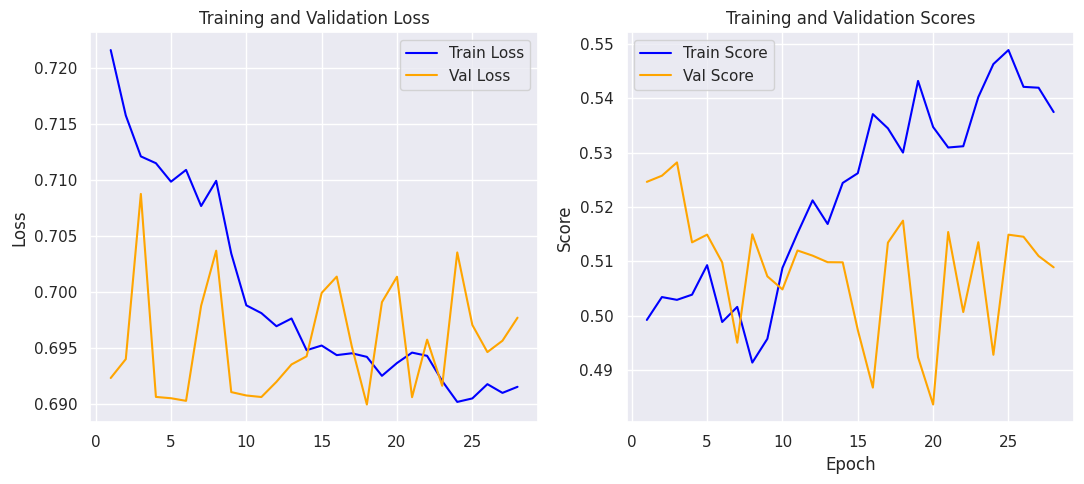

In [ ]:
plot_curves(res)

## InceptionTime

In [ ]:
class InceptionModule(Module):
    def __init__(self, ni, nf, ks=40, bottleneck=True, dropout=0.5):
        ks = [ks // (2**i) for i in range(3)]
        ks = [k if k % 2 != 0 else k - 1 for k in ks]  # ensure odd ks
        bottleneck = bottleneck if ni > 1 else False
        self.bottleneck = Conv1d(ni, nf, 1, bias=False) if bottleneck else noop
        self.convs = nn.ModuleList([Conv1d(nf if bottleneck else ni, nf, k, bias=False) for k in ks])
        self.maxconvpool = nn.Sequential(*[nn.MaxPool1d(3, stride=1, padding=1), Conv1d(ni, nf, 1, bias=False)])
        self.concat = Concat()
        self.bn = BN1d(nf * 4)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        input_tensor = x
        x = self.bottleneck(input_tensor)
        x = self.concat([l(x) for l in self.convs] + [self.maxconvpool(input_tensor)])
        x = self.bn(x)
        return self.dropout(self.act(x))


@delegates(InceptionModule.__init__)
class InceptionBlock(Module):
    def __init__(self, ni, nf=32, residual=True, depth=6, **kwargs):
        self.residual, self.depth = residual, depth
        self.inception, self.shortcut = nn.ModuleList(), nn.ModuleList()
        for d in range(depth):
            self.inception.append(InceptionModule(ni if d == 0 else nf * 4, nf, **kwargs))
            if self.residual and d % 3 == 2:
                n_in, n_out = ni if d == 2 else nf * 4, nf * 4
                self.shortcut.append(BN1d(n_in) if n_in == n_out else ConvBlock(n_in, n_out, 1, act=None))
        self.add = Add()
        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        for d, l in enumerate(range(self.depth)):
            x = self.inception[d](x)
            if self.residual and d % 3 == 2: res = x = self.act(self.add(x, self.shortcut[d//3](res)))
        return x


@delegates(InceptionModule.__init__)
class InceptionTime(Module):
    def __init__(self, c_in, c_out, seq_len=None, nf=32, nb_filters=None, **kwargs):
        nf = ifnone(nf, nb_filters) # for compatibility
        self.inceptionblock = InceptionBlock(c_in, nf, **kwargs)
        self.gap = GAP1d(1)
        self.fc = nn.Linear(nf * 4, c_out)

    def forward(self, x):
        x = self.inceptionblock(x)
        x = self.gap(x)
        x = self.fc(x)
        return x

In [ ]:
model = InceptionTime(4, 1, 14, nf=16, depth=3, dropout=0.4)
model

InceptionTime(
  (inceptionblock): InceptionBlock(
    (inception): ModuleList(
      (0): InceptionModule(
        (bottleneck): Conv1d(4, 16, kernel_size=(1,), stride=(1,), bias=False)
        (convs): ModuleList(
          (0): Conv1d(16, 16, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
          (1): Conv1d(16, 16, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
          (2): Conv1d(16, 16, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
        )
        (maxconvpool): Sequential(
          (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
          (1): Conv1d(4, 16, kernel_size=(1,), stride=(1,), bias=False)
        )
        (concat): Concat(dim=1)
        (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
        (dropout): Dropout(p=0.3, inplace=False)
      )
      (1-2): 2 x InceptionModule(
        (bottleneck): Conv1d(64, 16, kernel_size=(1,), stride=(1

In [ ]:
args = {
    'n_epochs': 100,
    'batch_size': 32,
    'lr': 1e-4,
    'weight_decay': 1e-5
}

res = trainer(train_data, val_data, model, args, early_stopping_rounds=5)

Epoch 1/100


100%|██████████| 320/320 [00:02<00:00, 145.37 batch/s]


Train Loss: 0.6902 | Val Loss: 0.6943 | Train Score: 0.5477 | Val Score: 0.4915
Epoch 2/100


100%|██████████| 320/320 [00:02<00:00, 146.22 batch/s]


Train Loss: 0.6741 | Val Loss: 0.6957 | Train Score: 0.6147 | Val Score: 0.5037
Epoch 3/100


100%|██████████| 320/320 [00:02<00:00, 111.26 batch/s]


Train Loss: 0.6555 | Val Loss: 0.6935 | Train Score: 0.6552 | Val Score: 0.5219
Epoch 4/100


100%|██████████| 320/320 [00:02<00:00, 148.44 batch/s]


Train Loss: 0.6439 | Val Loss: 0.6998 | Train Score: 0.6750 | Val Score: 0.5232
Epoch 5/100


100%|██████████| 320/320 [00:02<00:00, 148.58 batch/s]


Train Loss: 0.6344 | Val Loss: 0.7021 | Train Score: 0.6912 | Val Score: 0.5284
Epoch 6/100


100%|██████████| 320/320 [00:02<00:00, 149.41 batch/s]


Train Loss: 0.6324 | Val Loss: 0.7008 | Train Score: 0.6931 | Val Score: 0.5278
Epoch 7/100


100%|██████████| 320/320 [00:02<00:00, 144.98 batch/s]


Train Loss: 0.6235 | Val Loss: 0.7082 | Train Score: 0.7084 | Val Score: 0.5212
Epoch 8/100


100%|██████████| 320/320 [00:02<00:00, 111.55 batch/s]


Train Loss: 0.6174 | Val Loss: 0.7131 | Train Score: 0.7143 | Val Score: 0.5277
Epoch 9/100


100%|██████████| 320/320 [00:06<00:00, 50.13 batch/s]


Train Loss: 0.6142 | Val Loss: 0.7054 | Train Score: 0.7198 | Val Score: 0.5304
Epoch 10/100


100%|██████████| 320/320 [00:02<00:00, 139.26 batch/s]


Train Loss: 0.6052 | Val Loss: 0.7099 | Train Score: 0.7309 | Val Score: 0.5439
Epoch 11/100


100%|██████████| 320/320 [00:02<00:00, 149.19 batch/s]


Train Loss: 0.5991 | Val Loss: 0.7079 | Train Score: 0.7377 | Val Score: 0.5397
Epoch 12/100


100%|██████████| 320/320 [00:03<00:00, 102.05 batch/s]


Train Loss: 0.5909 | Val Loss: 0.7224 | Train Score: 0.7487 | Val Score: 0.5387
Epoch 13/100


100%|██████████| 320/320 [00:02<00:00, 146.64 batch/s]


Train Loss: 0.5892 | Val Loss: 0.7305 | Train Score: 0.7504 | Val Score: 0.5457
Epoch 14/100


100%|██████████| 320/320 [00:02<00:00, 147.71 batch/s]


Train Loss: 0.5863 | Val Loss: 0.7180 | Train Score: 0.7546 | Val Score: 0.5467
Epoch 15/100


100%|██████████| 320/320 [00:02<00:00, 145.53 batch/s]


Train Loss: 0.5775 | Val Loss: 0.7411 | Train Score: 0.7640 | Val Score: 0.5576
Epoch 16/100


100%|██████████| 320/320 [00:02<00:00, 145.36 batch/s]


Train Loss: 0.5803 | Val Loss: 0.7210 | Train Score: 0.7617 | Val Score: 0.5496
Epoch 17/100


100%|██████████| 320/320 [00:03<00:00, 103.50 batch/s]


Train Loss: 0.5728 | Val Loss: 0.7272 | Train Score: 0.7672 | Val Score: 0.5491
Epoch 18/100


100%|██████████| 320/320 [00:02<00:00, 145.71 batch/s]


Train Loss: 0.5679 | Val Loss: 0.7004 | Train Score: 0.7739 | Val Score: 0.5679
Epoch 19/100


100%|██████████| 320/320 [00:02<00:00, 146.73 batch/s]


Train Loss: 0.5653 | Val Loss: 0.7357 | Train Score: 0.7755 | Val Score: 0.5605
Epoch 20/100


100%|██████████| 320/320 [00:02<00:00, 146.80 batch/s]


Train Loss: 0.5634 | Val Loss: 0.7293 | Train Score: 0.7787 | Val Score: 0.5558
Epoch 21/100


100%|██████████| 320/320 [00:02<00:00, 147.85 batch/s]


Train Loss: 0.5563 | Val Loss: 0.7064 | Train Score: 0.7859 | Val Score: 0.5638
Epoch 22/100


100%|██████████| 320/320 [00:02<00:00, 108.34 batch/s]


Train Loss: 0.5491 | Val Loss: 0.7260 | Train Score: 0.7923 | Val Score: 0.5581
Epoch 23/100


100%|██████████| 320/320 [00:02<00:00, 147.74 batch/s]


Train Loss: 0.5527 | Val Loss: 0.7099 | Train Score: 0.7872 | Val Score: 0.5749
Epoch 24/100


100%|██████████| 320/320 [00:02<00:00, 144.94 batch/s]


Train Loss: 0.5465 | Val Loss: 0.7257 | Train Score: 0.7938 | Val Score: 0.5770
Epoch 25/100


100%|██████████| 320/320 [00:02<00:00, 147.26 batch/s]


Train Loss: 0.5491 | Val Loss: 0.7268 | Train Score: 0.7929 | Val Score: 0.5722
Epoch 26/100


100%|██████████| 320/320 [00:02<00:00, 148.27 batch/s]


Train Loss: 0.5373 | Val Loss: 0.7402 | Train Score: 0.8039 | Val Score: 0.5683
Epoch 27/100


100%|██████████| 320/320 [00:02<00:00, 114.78 batch/s]


Train Loss: 0.5406 | Val Loss: 0.7449 | Train Score: 0.8000 | Val Score: 0.5681
Epoch 28/100


100%|██████████| 320/320 [00:02<00:00, 131.60 batch/s]


Train Loss: 0.5336 | Val Loss: 0.7414 | Train Score: 0.8071 | Val Score: 0.5650
Epoch 29/100


100%|██████████| 320/320 [00:02<00:00, 145.28 batch/s]


Train Loss: 0.5376 | Val Loss: 0.7336 | Train Score: 0.8030 | Val Score: 0.5731
Early stopping at epoch 29


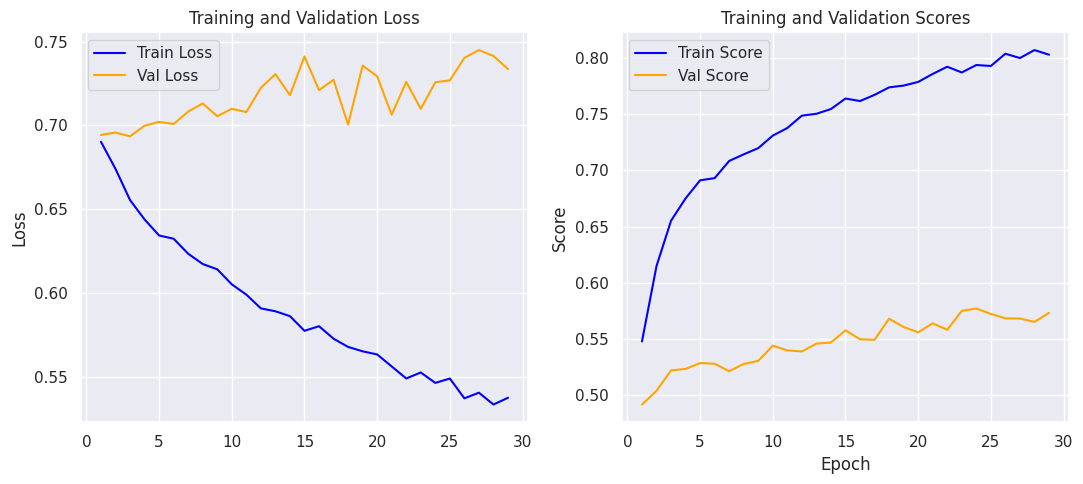

In [ ]:
plot_curves(res)

In [ ]:
args = {
    'n_epochs': 100,
    'batch_size': 32,
    'lr': 1e-4,
    'weight_decay': 1e-5
}
model = InceptionTime(4, 1, 14, nf=16, depth=3, dropout=0.6)
res = trainer(train_data, val_data, model, args, early_stopping_rounds=10)

Epoch 1/100


100%|██████████| 320/320 [00:03<00:00, 88.95 batch/s] 


Train Loss: 0.6951 | Val Loss: 0.6862 | Train Score: 0.5117 | Val Score: 0.6193
Epoch 2/100


100%|██████████| 320/320 [00:02<00:00, 146.57 batch/s]


Train Loss: 0.6902 | Val Loss: 0.6862 | Train Score: 0.5501 | Val Score: 0.6099
Epoch 3/100


100%|██████████| 320/320 [00:02<00:00, 128.97 batch/s]


Train Loss: 0.6853 | Val Loss: 0.6820 | Train Score: 0.5680 | Val Score: 0.6302
Epoch 4/100


100%|██████████| 320/320 [00:02<00:00, 118.66 batch/s]


Train Loss: 0.6832 | Val Loss: 0.6819 | Train Score: 0.5784 | Val Score: 0.6252
Epoch 5/100


100%|██████████| 320/320 [00:02<00:00, 145.44 batch/s]


Train Loss: 0.6771 | Val Loss: 0.6784 | Train Score: 0.5974 | Val Score: 0.6320
Epoch 6/100


100%|██████████| 320/320 [00:02<00:00, 147.18 batch/s]


Train Loss: 0.6716 | Val Loss: 0.6776 | Train Score: 0.6190 | Val Score: 0.6286
Epoch 7/100


100%|██████████| 320/320 [00:02<00:00, 143.03 batch/s]


Train Loss: 0.6673 | Val Loss: 0.6793 | Train Score: 0.6269 | Val Score: 0.6184
Epoch 8/100


100%|██████████| 320/320 [00:02<00:00, 132.05 batch/s]


Train Loss: 0.6645 | Val Loss: 0.6806 | Train Score: 0.6325 | Val Score: 0.6159
Epoch 9/100


100%|██████████| 320/320 [00:02<00:00, 117.32 batch/s]


Train Loss: 0.6605 | Val Loss: 0.6859 | Train Score: 0.6395 | Val Score: 0.6035
Epoch 10/100


100%|██████████| 320/320 [00:02<00:00, 145.20 batch/s]


Train Loss: 0.6572 | Val Loss: 0.6831 | Train Score: 0.6465 | Val Score: 0.5967
Epoch 11/100


100%|██████████| 320/320 [00:02<00:00, 145.72 batch/s]


Train Loss: 0.6552 | Val Loss: 0.6799 | Train Score: 0.6534 | Val Score: 0.6013
Epoch 12/100


100%|██████████| 320/320 [00:02<00:00, 148.13 batch/s]


Train Loss: 0.6547 | Val Loss: 0.6785 | Train Score: 0.6546 | Val Score: 0.5923
Epoch 13/100


100%|██████████| 320/320 [00:02<00:00, 133.19 batch/s]


Train Loss: 0.6550 | Val Loss: 0.6803 | Train Score: 0.6529 | Val Score: 0.5899
Epoch 14/100


100%|██████████| 320/320 [00:02<00:00, 111.23 batch/s]


Train Loss: 0.6518 | Val Loss: 0.6898 | Train Score: 0.6616 | Val Score: 0.5855
Epoch 15/100


100%|██████████| 320/320 [00:02<00:00, 146.89 batch/s]


Train Loss: 0.6468 | Val Loss: 0.6827 | Train Score: 0.6704 | Val Score: 0.5812
Early stopping at epoch 15


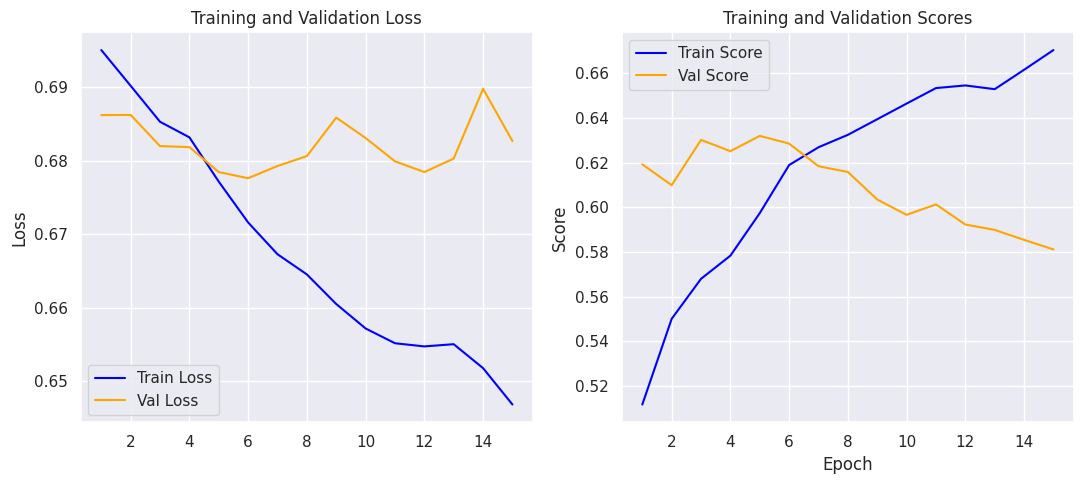

In [ ]:
plot_curves(res)